In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/forest_cover_classification_weekend_hackathon_12/Forest_Cover_participants_Data.zip

--2020-07-19 20:38:20--  https://machinehack-be.s3.amazonaws.com/forest_cover_classification_weekend_hackathon_12/Forest_Cover_participants_Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.32
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13633428 (13M) [application/zip]
Saving to: ‘Forest_Cover_participants_Data.zip’

Forest_Cover_partic 100%[===================>]  13.00M  5.06MB/s    in 2.6s    

2020-07-19 20:38:24 (5.06 MB/s) - ‘Forest_Cover_participants_Data.zip’ saved [13633428/13633428]



In [ ]:
!unzip Forest_Cover_participants_Data.zip

Archive:  Forest_Cover_participants_Data.zip
   creating: Forest_Cover_participants_Data/
  inflating: __MACOSX/._Forest_Cover_participants_Data  
  inflating: Forest_Cover_participants_Data/.DS_Store  
  inflating: __MACOSX/Forest_Cover_participants_Data/._.DS_Store  
  inflating: Forest_Cover_participants_Data/test.csv  
  inflating: __MACOSX/Forest_Cover_participants_Data/._test.csv  
  inflating: Forest_Cover_participants_Data/train.csv  
  inflating: __MACOSX/Forest_Cover_participants_Data/._train.csv  
  inflating: Forest_Cover_participants_Data/sample_submission.csv  
  inflating: __MACOSX/Forest_Cover_participants_Data/._sample_submission.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('Forest_Cover_participants_Data/train.csv')
test = pd.read_csv('Forest_Cover_participants_Data/test.csv')
sub = pd.read_csv('Forest_Cover_participants_Data/sample_submission.csv')

In [ ]:
train.tail(5)

,Elevation(meters),Aspect(degrees),Slope(degrees),Horizontal_Distance_To_Hydrology(meters),Vertical_Distance_To_Hydrology(meters),Horizontal_Distance_To_Roadways(meters),Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points(meters),Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
29045,2701,149,1,0,0,2207,221,238,154,607,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
29046,2929,129,10,150,36,351,237,234,127,297,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5
29047,3034,294,17,212,46,2671,172,234,202,1717,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7
29048,2730,122,9,360,106,1560,236,233,128,514,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
29049,3146,247,11,339,38,994,198,248,189,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [ ]:
test.head(5)

,Elevation(meters),Aspect(degrees),Slope(degrees),Horizontal_Distance_To_Hydrology(meters),Vertical_Distance_To_Hydrology(meters),Horizontal_Distance_To_Roadways(meters),Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points(meters),Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,2798,151,12,60,-5,3373,236,240,132,6083,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3582,96,34,420,80,2579,250,170,19,3771,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2619,171,12,270,-52,2764,228,245,147,2008,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2897,155,5,210,14,2437,226,240,149,2455,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2845,32,12,309,47,2778,217,213,129,42,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(Elevation(meters)                             0
 Aspect(degrees)                               0
 Slope(degrees)                                0
 Horizontal_Distance_To_Hydrology(meters)      0
 Vertical_Distance_To_Hydrology(meters)        0
 Horizontal_Distance_To_Roadways(meters)       0
 Hillshade_9am                                 0
 Hillshade_Noon                                0
 Hillshade_3pm                                 0
 Horizontal_Distance_To_Fire_Points(meters)    0
 Wilderness_Area_1                             0
 Wilderness_Area_2                             0
 Wilderness_Area_3                             0
 Wilderness_Area_4                             0
 Soil_Type_1                                   0
 Soil_Type_2                                   0
 Soil_Type_3                                   0
 Soil_Type_4                                   0
 Soil_Type_5                                   0
 Soil_Type_6                                   0
 Soil_Type_7        

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

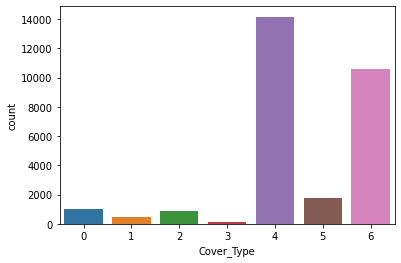

In [ ]:
train['Cover_Type']=train['Cover_Type']-1
import seaborn as sns
sns.countplot(train['Cover_Type'])


In [ ]:
train_df=train
test_df=test

In [ ]:

X = train_df.drop(labels=['Cover_Type'], axis=1)
y = train_df['Cover_Type'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((24692, 54), (24692,), (4358, 54), (4358,))

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 7,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.1, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.374659


KeyboardInterrupt: ignored

In [ ]:
log_loss(y_cv, y_pred)

0.3350717475208996

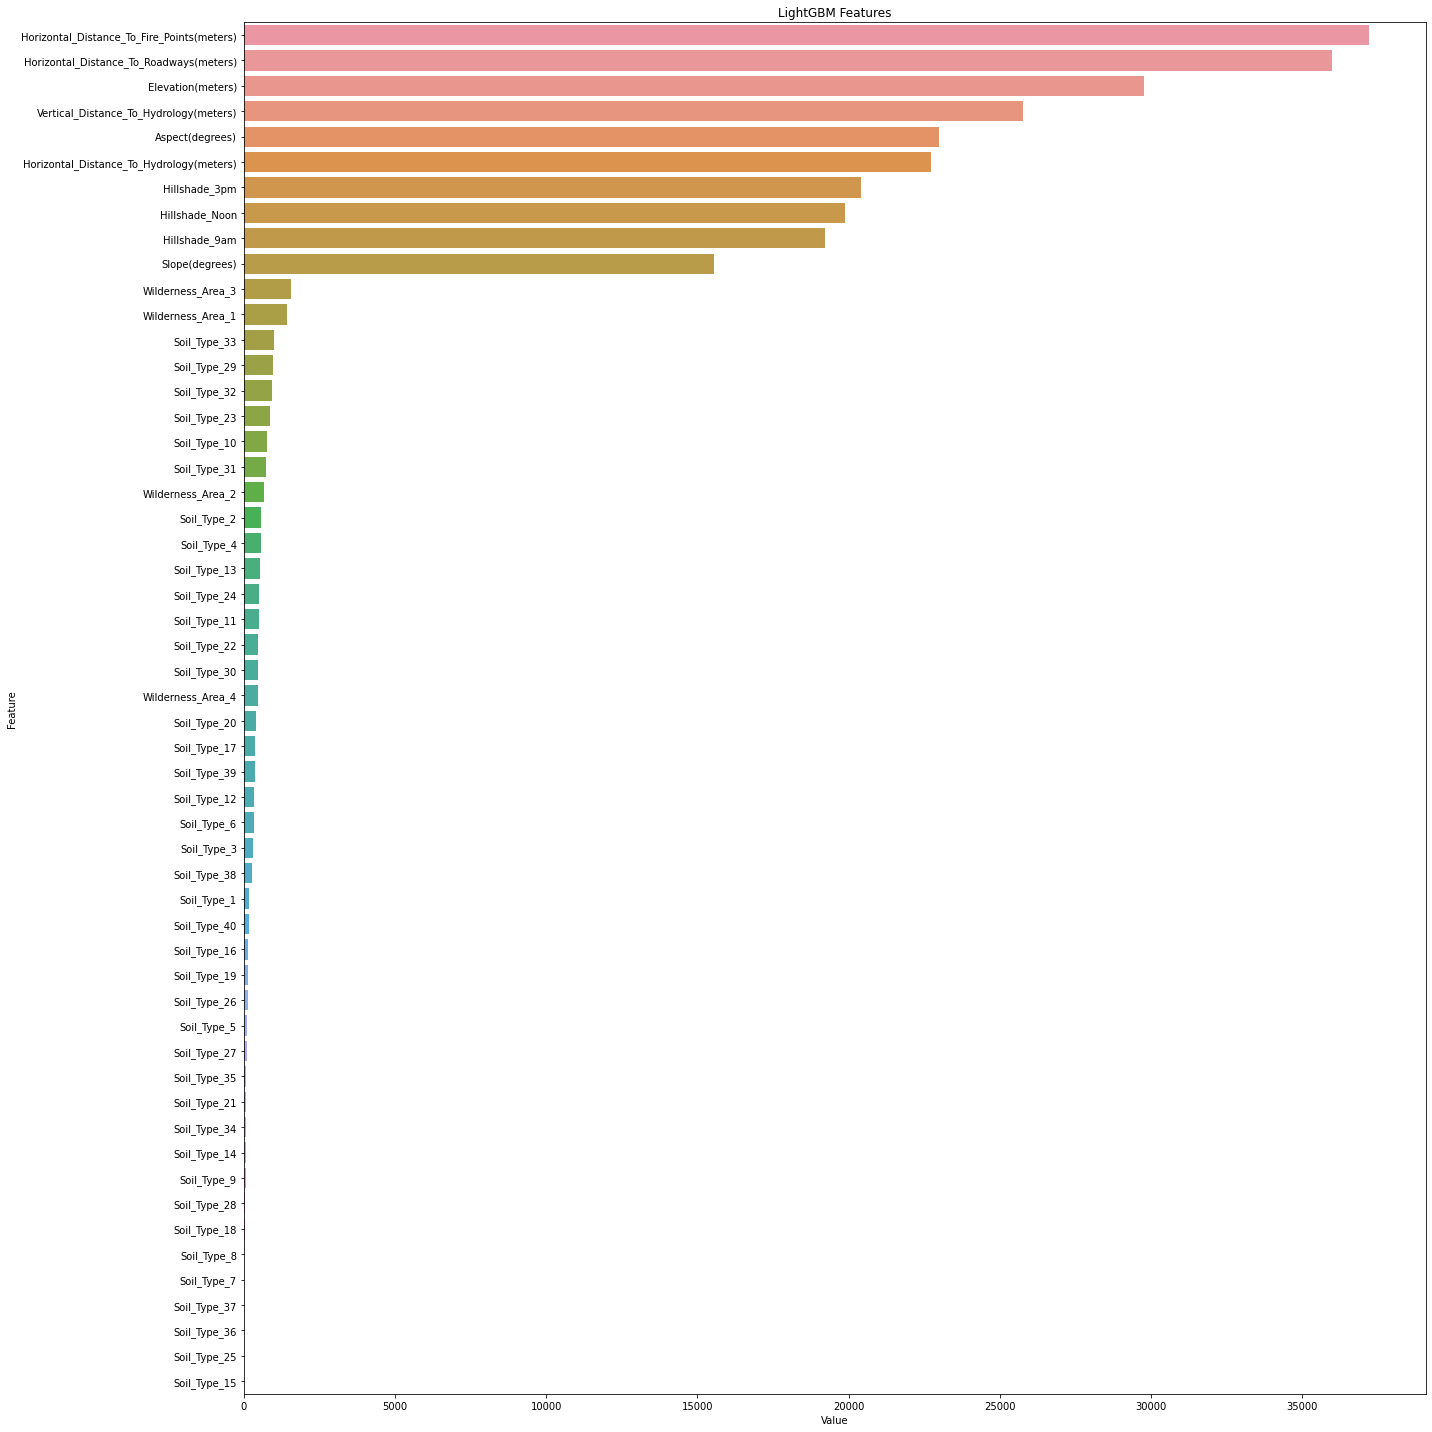

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

,Value,Feature
0,37228,Horizontal_Distance_To_Fire_Points(meters)
1,35998,Horizontal_Distance_To_Roadways(meters)
2,29782,Elevation(meters)
3,25779,Vertical_Distance_To_Hydrology(meters)
4,22986,Aspect(degrees)
5,22734,Horizontal_Distance_To_Hydrology(meters)
6,20398,Hillshade_3pm
7,19875,Hillshade_Noon
8,19227,Hillshade_9am
9,15549,Slope(degrees)


In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.394976
[200]	valid_0's multi_logloss: 0.366666
[300]	valid_0's multi_logloss: 0.363227
[400]	valid_0's multi_logloss: 0.364326
[500]	valid_0's multi_logloss: 0.366239
Early stopping, best iteration is:
[336]	valid_0's multi_logloss: 0.36204
Log Loss:  0.36204018558783585


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.389444
[200]	valid_0's multi_logloss: 0.363913
[300]	valid_0's multi_logloss: 0.356597
[400]	valid_0's multi_logloss: 0.353823
[500]	valid_0's multi_logloss: 0.355669
Early stopping, best iteration is:
[358]	valid_0's multi_logloss: 0.352861
Log Loss:  0.352861194531558


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.374696
[200]	valid_0's multi_logloss: 0.342367
[300]	valid_0's multi_logloss: 0.333211
[400]	valid_0's multi_logloss: 0.331823
[500]	valid_0's multi_logloss: 0.334544
[600]	valid_0's multi_logloss: 0.337197
Early stopping, best iteration is:
[427]	valid_0's multi_logloss: 0.331384
Log Loss:  0.331383895268393


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.386016
[200]	valid_0's multi_logloss: 0.353437
[300]	valid_0's multi_logloss: 0.344984
[400]	valid_0's multi_logloss: 0.341601
[500]	valid_0's multi_logloss: 0.342009
[600]	valid_0's multi_logloss: 0.344196
Early stopping, best iteration is:
[431]	valid_0's multi_logloss: 0.340972
Log Loss:  0.34097231943927403


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.37235
[200]	valid_0's multi_logloss: 0.336866
[300]	valid_0's multi_logloss: 0.326794
[400]	valid_0's multi_logloss: 0.323674
[500]	valid_0's multi_logloss: 0.324924
Early stopping, best iteration is:
[392]	valid_0's multi_logloss: 0.32353
Log Loss:  0.32353000375147334


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.386956
[200]	valid_0's multi_logloss: 0.363341
[300]	valid_0's multi_logloss: 0.359882
[400]	valid_0's multi_logloss: 0.359988
[500]	valid_0's multi_logloss: 0.364436
Early stopping, best iteration is:
[347]	valid_0's multi_logloss: 0.358258
Log Loss:  0.35825760274468577


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.401637
[200]	valid_0's multi_logloss: 0.378289
[300]	valid_0's multi_logloss: 0.373453
[400]	valid_0's multi_logloss: 0.374443
Early stopping, best iteration is:
[292]	valid_0's multi_logloss: 0.373098
Log Loss:  0.37309751910878153


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.377007
[200]	valid_0's multi_logloss: 0.352284
[300]	valid_0's multi_logloss: 0.344606
[400]	valid_0's multi_logloss: 0.344569
[500]	valid_0's multi_logloss: 0.34868
Early stopping, best iteration is:
[367]	valid_0's multi_logloss: 0.34373
Log Loss:  0.3437301924780601


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.373525
[200]	valid_0's multi_logloss: 0.345522
[300]	valid_0's multi_logloss: 0.339031
[400]	valid_0's multi_logloss: 0.339224
[500]	valid_0's multi_logloss: 0.340632
Early stopping, best iteration is:
[361]	valid_0's multi_logloss: 0.338091
Log Loss:  0.33809062913430765


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.41477
[200]	valid_0's multi_logloss: 0.390831
[300]	valid_0's multi_logloss: 0.387278
[400]	valid_0's multi_logloss: 0.389871
Early stopping, best iteration is:
[282]	valid_0's multi_logloss: 0.387097
Log Loss:  0.3870968090546032


In [ ]:
np.mean(errlgb,0)

0.35110603510989724

In [ ]:
sub.columns

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], dtype='object')

In [ ]:
y_pred = np.mean(y_pred_totlgb,0)

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,0.000002,3.048424e-05,1.560944e-06,4.963907e-07,0.994957,6.562729e-06,0.005003
1,0.991898,2.443645e-07,7.036293e-08,7.124335e-08,0.000019,1.588614e-07,0.008082
2,0.000010,2.443877e-04,1.201763e-04,1.623466e-06,0.995490,1.530696e-03,0.002603
3,0.000014,7.895911e-04,2.459591e-06,1.388829e-06,0.984388,2.804334e-05,0.014776
4,0.000014,6.665264e-05,6.063298e-05,3.253076e-06,0.259462,5.530908e-05,0.740338


In [ ]:
submission.to_csv('alpha3.csv',index=False)

In [ ]:
from google.colab import files
files.download('alpha1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_cv)

log_loss(y_cv, y_pred)

0.5958925520053099

In [ ]:
Xtest = test_df

In [ ]:
err = []
y_pred_tot = []

fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict_proba(X_test)
    
    print("Log Loss:", log_loss(y_test, y_pred))

    err.append(log_loss(y_test, y_pred))
    p = xgb.predict_proba(Xtest)
    y_pred_tot.append(p)

Log Loss: 0.5895552602544648
Log Loss: 0.610655400194597
Log Loss: 0.5936660712395588
Log Loss: 0.6073081570518585
Log Loss: 0.6028971432826904
Log Loss: 0.6035230365847105


In [ ]:
np.mean(err, 0)

0.6012675114346466

In [ ]:
np.mean(y_pred_tot, 0)

array([[5.9621740e-04, 5.2068071e-03, 1.1139885e-03, ..., 8.7281102e-01,
        1.7026818e-03, 1.1812190e-01],
       [4.2670381e-01, 5.4600026e-04, 6.3463283e-04, ..., 1.9831076e-02,
        4.9506564e-04, 5.5131912e-01],
       [6.2699255e-04, 2.6836595e-02, 3.9252583e-02, ..., 6.2206703e-01,
        2.5145423e-01, 5.9292983e-02],
       ...,
       [9.4200188e-04, 6.5769330e-02, 1.0193513e-03, ..., 6.9403595e-01,
        1.2682243e-03, 2.3625897e-01],
       [7.6182728e-04, 8.3385175e-04, 6.8411697e-04, ..., 5.5181664e-01,
        1.0011859e-03, 4.4433120e-01],
       [9.7465917e-04, 3.6605831e-02, 2.3265099e-03, ..., 7.9715890e-01,
        4.6017002e-03, 1.5758435e-01]], dtype=float32)

In [ ]:
y_pred = np.mean(y_pred_tot, 0)

In [ ]:
sub = pd.DataFrame(y_pred)
sub.head(5)

,0,1,2,3,4,5,6
0,0.000596,0.005207,0.001114,0.000447,0.872811,0.001703,0.118122
1,0.426704,0.000546,0.000635,0.000470,0.019831,0.000495,0.551319
2,0.000627,0.026837,0.039253,0.000470,0.622067,0.251454,0.059293
3,0.000962,0.036202,0.001182,0.000721,0.807239,0.001442,0.152252
4,0.001067,0.029276,0.001736,0.000799,0.764950,0.007822,0.194351


In [ ]:
sub.to_csv('s1.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.15, random_state=101, stratify=y)

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 7,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.1, 
         'num_iterations': 1000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':False
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.382083
[200]	valid_0's multi_logloss: 0.352242
[300]	valid_0's multi_logloss: 0.344192
[400]	valid_0's multi_logloss: 0.342494
[500]	valid_0's multi_logloss: 0.344052
Early stopping, best iteration is:
[377]	valid_0's multi_logloss: 0.342094


In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=False, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    param = {'objective': 'multiclass',
         'num_class': 7,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.2, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':False
         }
    clf = lgb.train(params=param,
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.360856
[200]	valid_0's multi_logloss: 0.355143
[300]	valid_0's multi_logloss: 0.360208
Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.354274
Log Loss:  0.3542738856131831


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.370553
[200]	valid_0's multi_logloss: 0.364732
[300]	valid_0's multi_logloss: 0.3739
Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.362759
Log Loss:  0.3627586432361691


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.37959
[200]	valid_0's multi_logloss: 0.368946
[300]	valid_0's multi_logloss: 0.375063
Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 0.367922
Log Loss:  0.3679223446843055


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.369317
[200]	valid_0's multi_logloss: 0.367394
[300]	valid_0's multi_logloss: 0.378819
Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.363213
Log Loss:  0.3632131070721014


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.344395
[200]	valid_0's multi_logloss: 0.333227
[300]	valid_0's multi_logloss: 0.337657
[400]	valid_0's multi_logloss: 0.346531
Early stopping, best iteration is:
[236]	valid_0's multi_logloss: 0.332736
Log Loss:  0.3327360816095151


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.383333
[200]	valid_0's multi_logloss: 0.384229
[300]	valid_0's multi_logloss: 0.396339
Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.379021
Log Loss:  0.3790212593651385


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.366574
[200]	valid_0's multi_logloss: 0.36109
[300]	valid_0's multi_logloss: 0.370351
Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 0.360387
Log Loss:  0.36038676273939696


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.36976
[200]	valid_0's multi_logloss: 0.367393
[300]	valid_0's multi_logloss: 0.374713
Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.365196
Log Loss:  0.36519566596761166


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.367311
[200]	valid_0's multi_logloss: 0.358931
[300]	valid_0's multi_logloss: 0.365167
Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.357996
Log Loss:  0.3579964653963673


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.350391
[200]	valid_0's multi_logloss: 0.341252
[300]	valid_0's multi_logloss: 0.345097
Early stopping, best iteration is:
[177]	valid_0's multi_logloss: 0.338941
Log Loss:  0.33894116520707956


In [ ]:
np.mean(errlgb,0)

0.3582445380890868

In [ ]:

sub.columns

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], dtype='object')

In [ ]:
y_pred = np.mean(y_pred_totlgb,0)

In [ ]:

submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,0.000001,2.155995e-05,1.747098e-06,4.176026e-07,0.995092,7.413459e-06,0.004876
1,0.992304,3.021152e-07,1.099096e-07,7.889115e-08,0.000017,2.096399e-07,0.007678
2,0.000009,5.284573e-04,1.265759e-04,1.492328e-06,0.994459,1.885105e-03,0.002991
3,0.000016,1.076327e-03,2.287815e-06,1.401277e-06,0.981322,3.569652e-05,0.017546
4,0.000016,6.776055e-05,4.336966e-05,3.035451e-06,0.249376,6.225514e-05,0.750431


In [ ]:

submission.to_csv('final.csv', index=False)

In [ ]:

from google.colab import files
files.download('final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>